# Clustering analysis on 10k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os, sys

sys.path.append('../src')

from imp import load_source
from models import *

W0906 14:54:47.617116 4624954816 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'batch_size': 35,
    'epochs': 5 #200
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Build the full model

model.build_model()

In [9]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,5,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1789)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          358000      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC10k/graphs/autoencoder.png)

### Train the model

Epoch 5/5, rec. loss: 1.304225, dis. loss: 0.712562


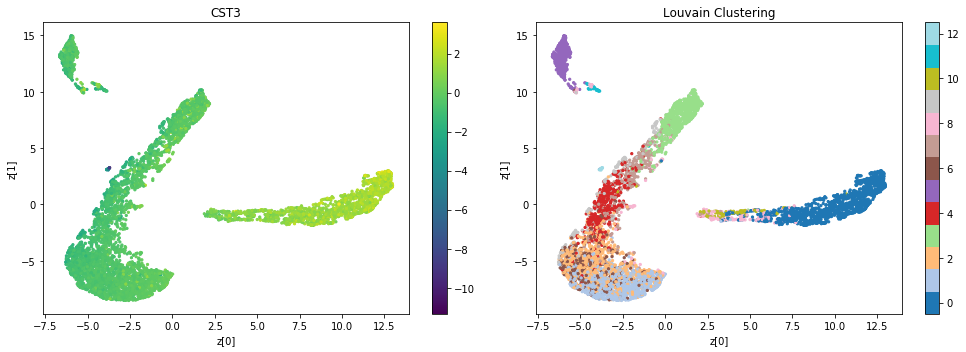

Training completed.
All networks exported in h5 format.


In [12]:
# graph=True to show the data points in the 2-D latent space

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GENE = 'CST3' # used only for training visualization 

rec_loss, dis_loss = model.train(graph=True, gene=GENE, log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC10k/

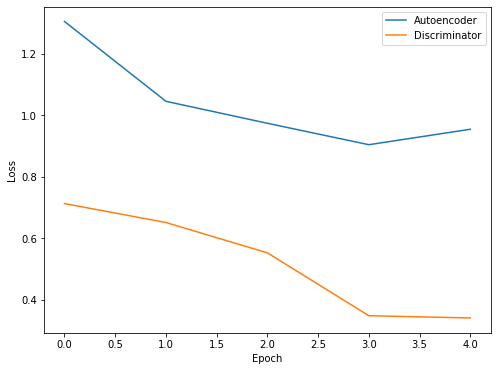

In [13]:
# Plot training loss values
steps = int(len(model.data)/model.batch_size)

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss[::steps])
plt.plot(dis_loss[::steps])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

W0906 14:59:09.667557 4624954816 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


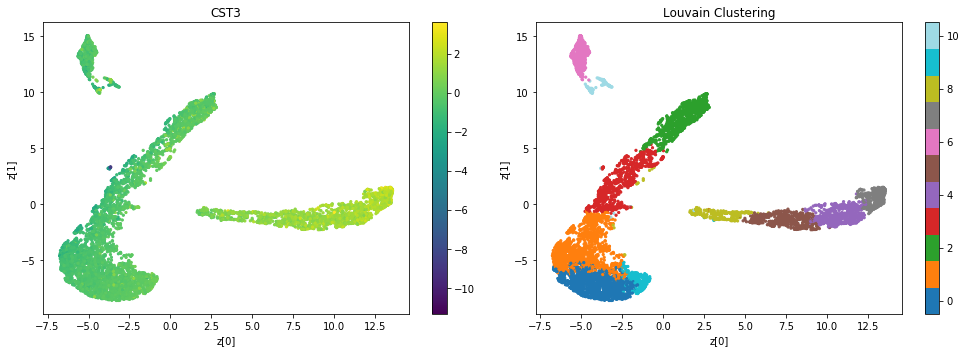

ARI = 0.4419338988184383
AMI = 0.6192109014112571


In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/AAE1/PBMC10k/'
model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

model.update_labels(res=0.6)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [6]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 18,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 35,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [7]:
model = AAE2(**parameters)

In [8]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [9]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [10]:
# Build the full model

model.build_model()

In [11]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,200,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [12]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          358000      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
____________________________________________________________________________________________

__________________________________________________________________________________________________
H_3 (Dense)                     (None, 100)          5100        D_2[0][0]                        
__________________________________________________________________________________________________
BN_3 (BatchNormalization)       (None, 100)          400         H_3[0][0]                        
__________________________________________________________________________________________________
LR_3 (LeakyReLU)                (None, 100)          0           BN_3[0][0]                       
__________________________________________________________________________________________________
D_3 (Dropout)                   (None, 100)          0           LR_3[0][0]                       
__________________________________________________________________________________________________
H_4 (Dense)                     (None, 200)          20200       D_3[0][0]                        
__________

_________________________________________________________________
BN_4 (BatchNormalization)    (None, 30)                120       
_________________________________________________________________
LR_4 (LeakyReLU)             (None, 30)                0         
_________________________________________________________________
D_4 (Dropout)                (None, 30)                0         
_________________________________________________________________
Check (Dense)                (None, 1)                 31        
Total params: 32,031
Trainable params: 31,271
Non-trainable params: 760
_________________________________________________________________


In [13]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs('../results/AAE2/PBMC10k/graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs


ENCODER


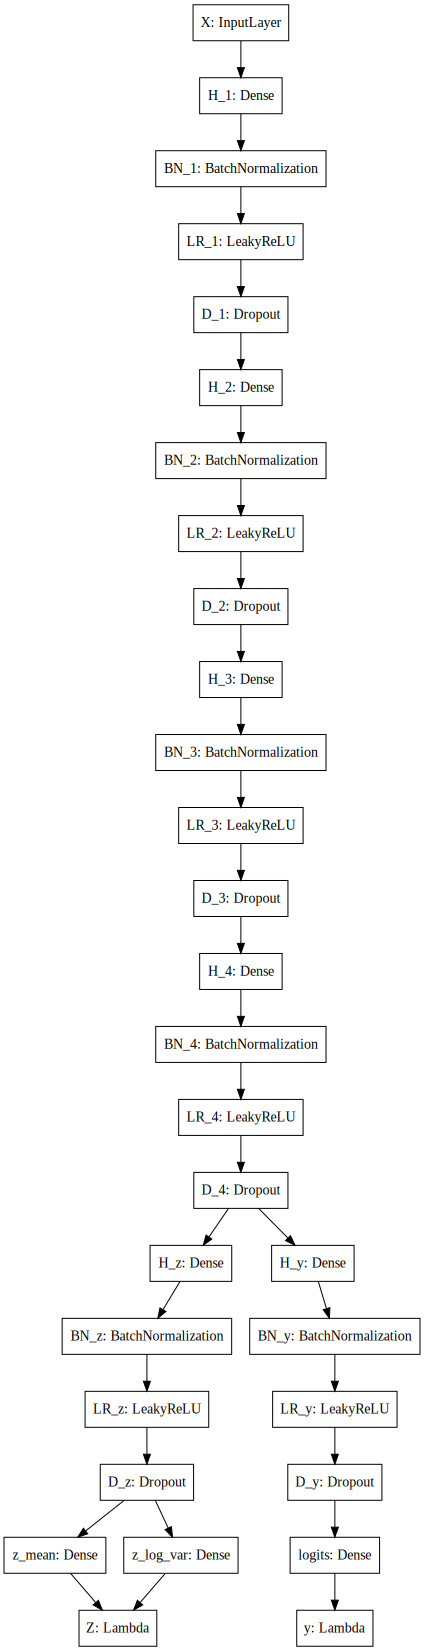

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


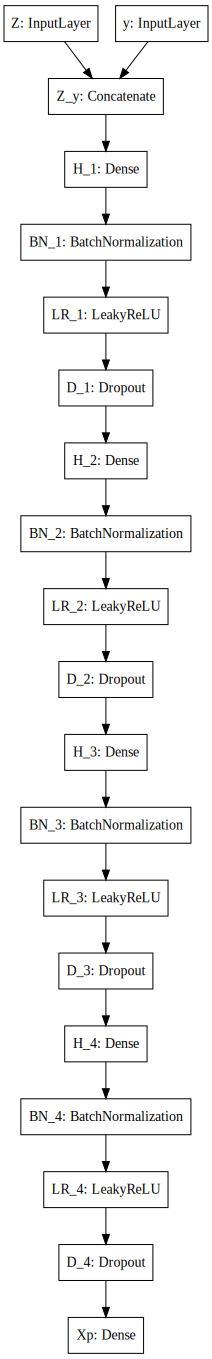

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


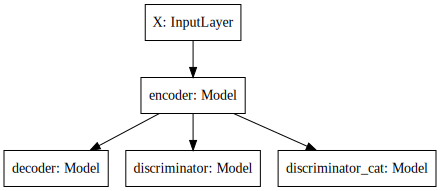

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


DISCRIMINATOR


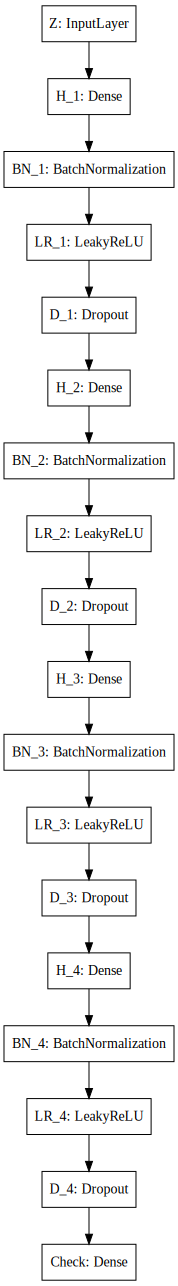

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))


CATEGORICAL DISCRIMINATOR


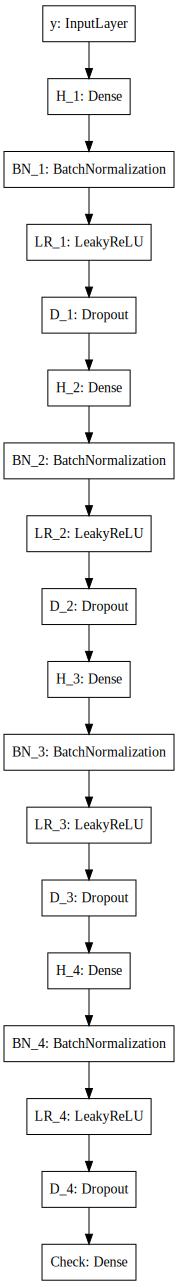

In [16]:
print("\nCATEGORICAL DISCRIMINATOR")
print("=========================")
SVG(model_to_dot(model.discriminator_cat).create(prog='dot', format='svg'))

### Train the model


Epoch 200/200, rec. loss: 1.327428, dis. loss: 0.907926, cat. dis. loss: 0.704799


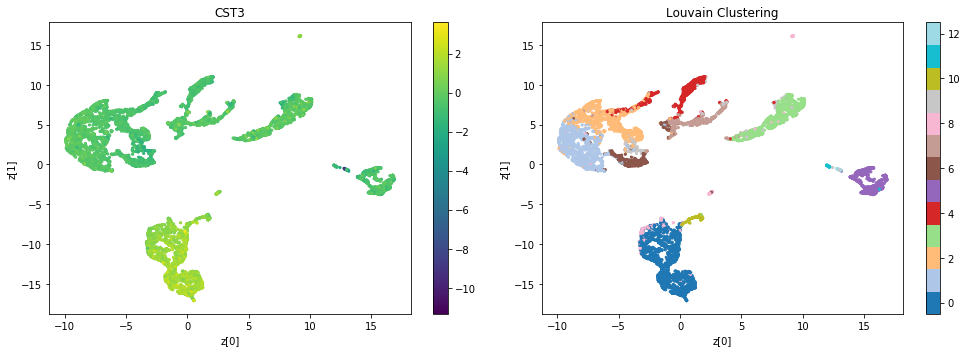

Training completed.
All networks exported in h5 format.
Latent space embedding completed.


In [14]:
# graph=True to show the data points in the 2-D latent space

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GENE = 'CST3' # used only for training visualization 

rec_loss, dis_loss, dis_cat_loss = model.train(graph=True, gene=GENE, log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE5/PBMC10k/

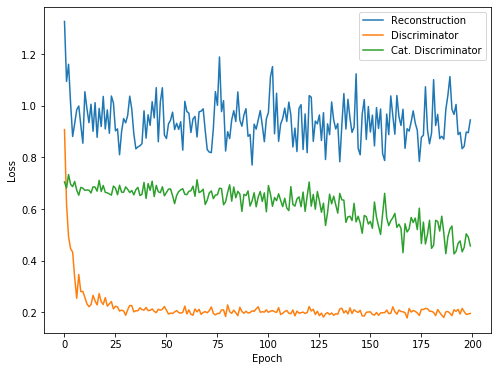

In [15]:
# Plot training loss values
steps = int(len(model.data)/model.batch_size)


plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss[::steps])
plt.plot(dis_loss[::steps])
plt.plot(dis_cat_loss[::steps])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], 
           loc='upper right')
plt.show()

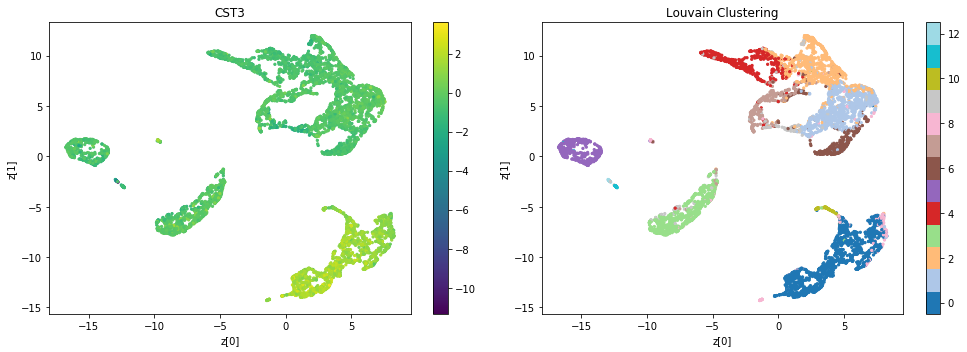

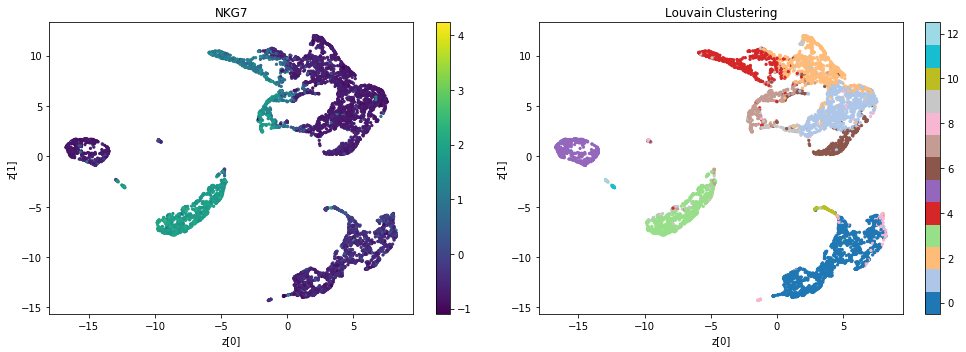

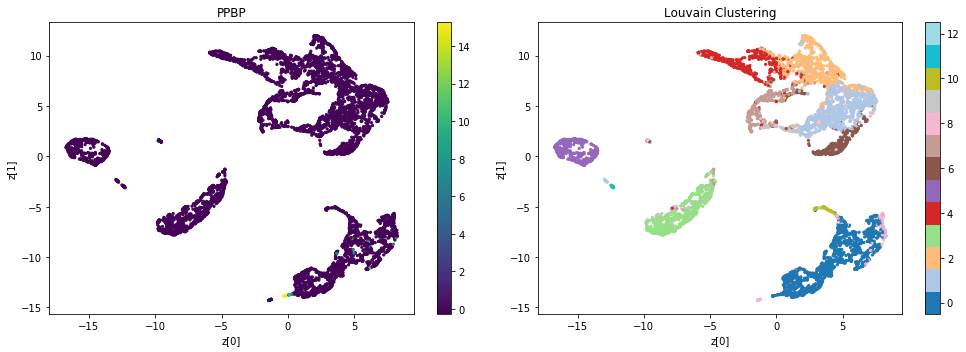

In [16]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

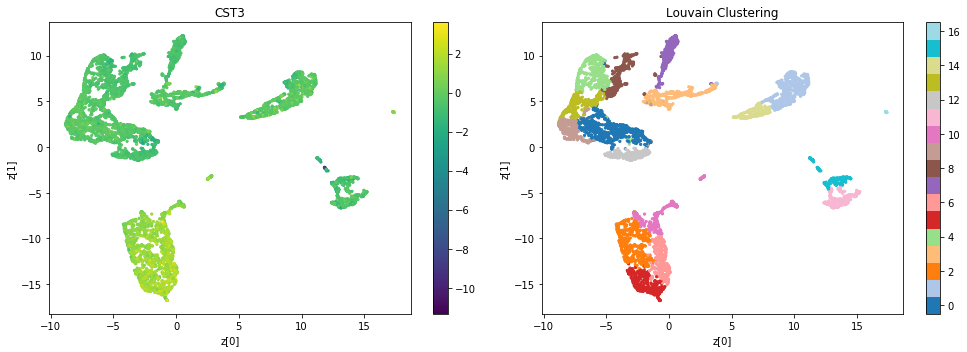

ARI = 0.4819383594641788
AMI = 0.6264953694189789


In [17]:
from keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/AAE2/PBMC10k/'
model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

model.update_labels(res=0.6)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'batch_size': 35,
    'epochs': 5 #500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,5,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

model.build_model()

W0905 18:59:27.150791 4648326592 training_utils.py:1346] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1789)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          358000      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

tf_op_layer_mul (TensorFlowOpLa [(None,)]            0           tf_op_layer_Mean[0][0]           
__________________________________________________________________________________________________
tf_op_layer_mul_1 (TensorFlowOp [(None,)]            0           tf_op_layer_Sum[0][0]            
__________________________________________________________________________________________________
tf_op_layer_add_1 (TensorFlowOp [(None,)]            0           tf_op_layer_mul[0][0]            
                                                                 tf_op_layer_mul_1[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Mean_1 (TensorFlowO [()]                 0           tf_op_layer_add_1[0][0]          
__________________________________________________________________________________________________
add_loss (AddLoss)              ()                   0           tf_op_layer_Mean_1[0][0]         
Total para

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC10k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC10k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC10k/graphs/autoencoder.png)

### Train the model

In [12]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

loss, val_loss = model.train(val_split=0.2, log_dir=log_dir)

Start model training...
Train on 6000 samples, validate on 1500 samples
Epoch 1/5
6000/6000 [==============================] - 5s 849us/sample - loss: 1983.5541 - val_loss: 1986.3957
Epoch 2/5
6000/6000 [==============================] - 3s 421us/sample - loss: 1818.8867 - val_loss: 1858.4035
Epoch 3/5
6000/6000 [==============================] - 2s 405us/sample - loss: 1792.2718 - val_loss: 1825.2233
Epoch 4/5
6000/6000 [==============================] - 2s 406us/sample - loss: 1764.5869 - val_loss: 1775.7166
Epoch 5/5
6000/6000 [==============================] - 3s 426us/sample - loss: 1734.7879 - val_loss: 1765.5501
Training completed.
All networks exported in h5 format.


In [ ]:
# !tensorboard --logdir=../results/VAE/PBMC10k/

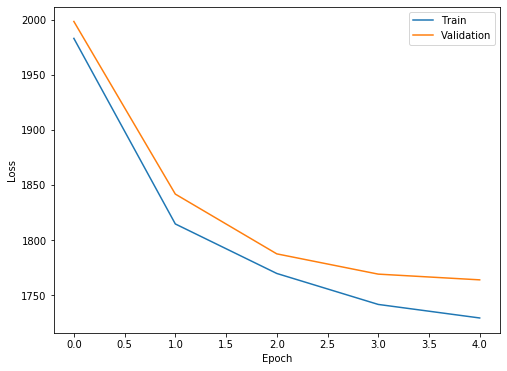

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

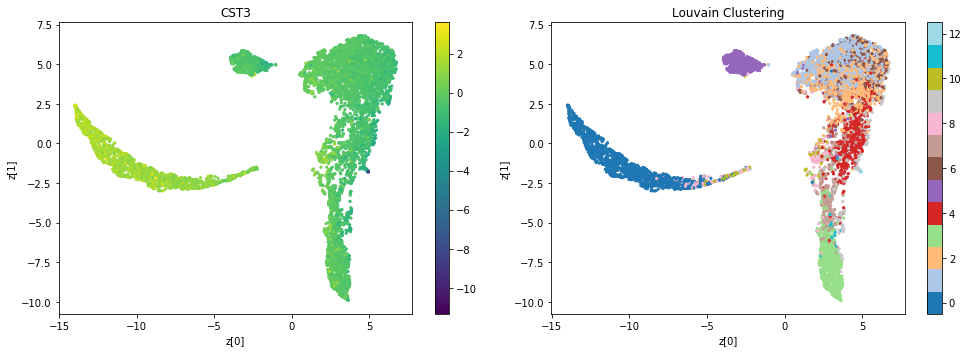

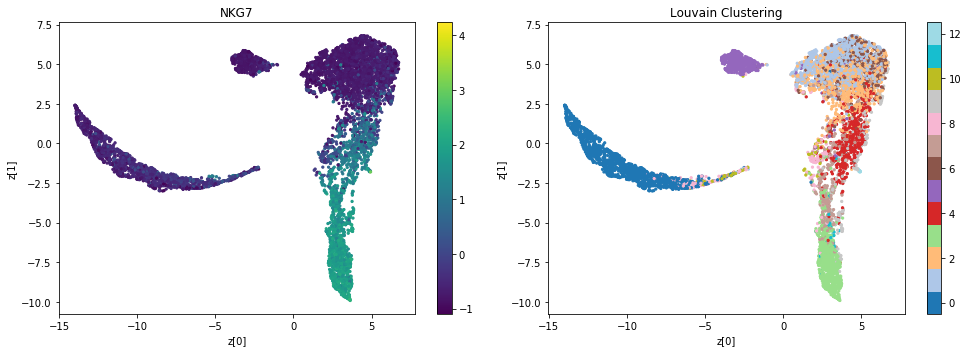

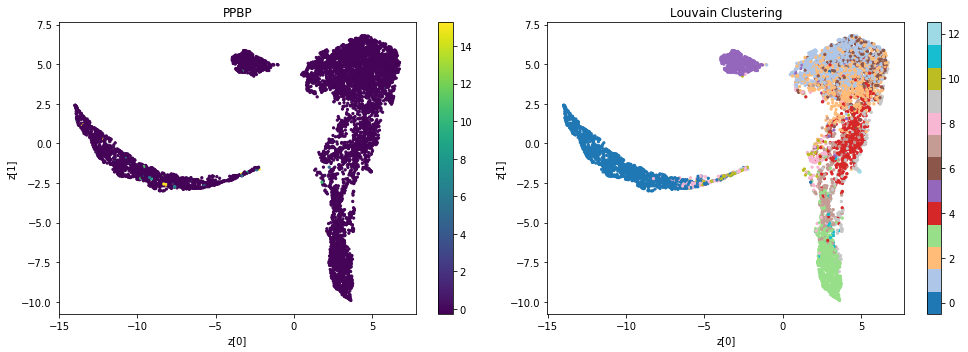

In [14]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

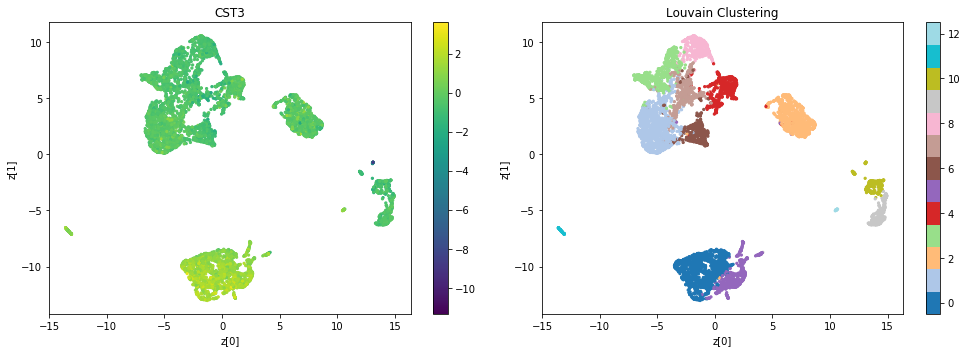

In [16]:
from tensorflow.keras.models import load_model

log_dir = '../results/VAE/PBMC10k/'
model.encoder = load_model(log_dir + 'models/encoder.h5')

model.update_labels(res=0.6)

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)